In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import os

import xgboost
from sklearn.model_selection import train_test_split

import slice_finding as sf
from importlib import reload
reload(sf);

/Users/vsivaram/anaconda3/envs/slice-finding/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("example_data/adult.csv")
df.head()
print (len(df))

48842


In [3]:
def _assign_bin_values(col_data, bin_spec):
    lower = bin_spec.get("min", np.quantile(col_data, 0.25))
    upper = bin_spec.get("max", np.quantile(col_data, 0.75))
    assert lower < upper, (lower, upper)
    return np.digitize(col_data, [lower, upper])

def extreme_value_binning(col_name, col_data, gender_data):
    if col_name not in NORMAL_RANGES:
        return np.digitize(col_data, np.quantile(col_data, [0.25, 0.75]))
    norm_range = NORMAL_RANGES[col_name]
    if "female" in norm_range:
        return np.where(gender_data, 
                        _assign_bin_values(col_data, norm_range["female"]),
                        _assign_bin_values(col_data, norm_range["male"]))
    return _assign_bin_values(col_data, norm_range)

def discretize_data(df, spec):
    discrete_columns = {}
    for col, col_spec in spec.items():
        if callable(col_spec["method"]):
            discrete_columns[col] = col_spec["method"](df[col], col)
        elif col_spec["method"] == "keep":
            discrete_columns[col] = df[col].values
        elif col_spec["method"] == "bin":
            discrete_columns[col] = np.digitize(df[col], col_spec["bins"]) - 1
        elif col_spec["method"] == "unique":
            unique_vals = sorted(df[col].unique().tolist())
            discrete_columns[col] = df[col].apply(lambda v: unique_vals.index(v))
    return pd.DataFrame(discrete_columns, index=df.index)

discrete_df = discretize_data(df, {
    'age': { "method": "bin", "bins": [0, 25, 45, 65] }, 
    'workclass': { "method": "unique" }, 
    'education': { "method": "unique" }, 
    'marital-status': { "method": "unique" }, 
    'occupation': { "method": "unique" }, 
    'relationship': { "method": "unique" }, 
    'race': { "method": "unique" }, 
    'gender': { "method": "unique" },   
    'capital-gain': { "method": "bin", "bins": [0, 1] }, 
    'capital-loss': { "method": "bin", "bins": [0, 1] }, 
    'hours-per-week': { "method": "bin", "bins": [0, 39] }, 
    'native-country': { "method": lambda x, c: x != 'United-States' },
})

In [4]:
df_prepped = df.drop(columns=['fnlwgt', 'educational-num'])

X = df_prepped.drop(columns=['income'])
y = df_prepped['income'] == '>50K'

X_continous  = X[['age', 'capital-gain', 'capital-loss', 'hours-per-week']]
print (X_continous.head())
X_categorical = X[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race',
                   'gender', 'native-country']]
print (X_categorical.head())
X_encoded = pd.get_dummies(X_categorical)
print ("encoded:")
print ("")
print (X_encoded)

X = pd.concat([X_continous, X_encoded], axis=1)

   age  capital-gain  capital-loss  hours-per-week
0   25             0             0              40
1   38             0             0              50
2   28             0             0              40
3   44          7688             0              40
4   18             0             0              30
   workclass     education      marital-status         occupation  \
0    Private          11th       Never-married  Machine-op-inspct   
1    Private       HS-grad  Married-civ-spouse    Farming-fishing   
2  Local-gov    Assoc-acdm  Married-civ-spouse    Protective-serv   
3    Private  Some-college  Married-civ-spouse  Machine-op-inspct   
4          ?  Some-college       Never-married                  ?   

  relationship   race  gender native-country  
0    Own-child  Black    Male  United-States  
1      Husband  White    Male  United-States  
2      Husband  White    Male  United-States  
3      Husband  Black    Male  United-States  
4    Own-child  White  Female  United-States

In [5]:
import os

if not os.path.exists("example_data/adult_model.json"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)

    print(model.score(X_test, y_test))

    model.save_model("example_data/adult_model.json")
else:
    model = xgboost.XGBClassifier()
    model.load_model("example_data/adult_model.json")

In [6]:
outcome_bins = 10
model_preds = model.predict(X)
discrete_outcomes = model_preds == y # df["income"] == ">50K"
print(discrete_outcomes.mean())

# Set up score functions
score_functions = {
    "error_rate": sf.OutcomeRateScore(1 - discrete_outcomes.values),
    "group_size": sf.SliceSizeScore(0.5, spread=0.25),
}

# the slices must contain at least this fraction of the dataset.
# a higher value would mean that fewer slices are eligible, and
# also that sampling is more likely to work well
min_items = int(len(discrete_df) * 0.05)
# 0.05, 0.01, 0.005, 0.001

num_slices_to_return = 50

max_features = 3

0.885262683755784


/Users/vsivaram/anaconda3/envs/slice-finding/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## Run recursive implementation

In [7]:
results = sf.find_slices(
    discrete_df.astype(int),
    score_functions,
    min_items=min_items, 
    n_slices=num_slices_to_return,
    algorithm='recursive',
    max_features=max_features,
)

Slice finding for 1 feature(s)
Done for:  1 , scored 72 slices
Slice finding for 2 feature(s)
Done for:  2 , scored 2238 slices
Slice finding for 3 feature(s)
Done for:  3 , scored 39716 slices


In [45]:
results

[<Slice: marital-status: 2, capital-gain: 0, capital-loss: 0; scores: error_rate: 2.169357076932543, group_size: 0.8813836002943677>,
 <Slice: relationship: 0, capital-gain: 0, capital-loss: 0; scores: error_rate: 2.206843083866321, group_size: 0.7923926444658831>,
 <Slice: marital-status: 2, capital-gain: 0, native-country: 0; scores: error_rate: 2.1137159003117536, group_size: 0.8543995460459352>,
 <Slice: marital-status: 2, capital-gain: 0, hours-per-week: 1; scores: error_rate: 2.141248023699382, group_size: 0.8267945223050006>,
 <Slice: marital-status: 2, capital-gain: 0; scores: error_rate: 2.036713578614197, group_size: 0.9278642766186211>,
 <Slice: relationship: 0, capital-gain: 0, hours-per-week: 1; scores: error_rate: 2.168556462217374, group_size: 0.7601047740595192>,
 <Slice: marital-status: 2, race: 4, capital-gain: 0; scores: error_rate: 2.0625369254809605, group_size: 0.8560838311019832>,
 <Slice: marital-status: 2, relationship: 0, capital-gain: 0; scores: error_rate: 2

## Run sampling implementation

In [46]:
def get_sampling_avg_recall_random(number_of_samples, number_of_iterations):
    results_sampling_unranked_random = []
    
    for i in range(number_of_iterations):
        tmp_results_sampling_unranked_random = sf.find_slices(
            discrete_df.astype(int),
            score_functions,
            algorithm='sampling',
            source_mask=None,
            min_items=min_items,
            num_samples=number_of_samples,
            num_candidates=None,
            max_features=max_features
        )
        tmp_results_sampling_random = tmp_results_sampling_unranked_random.rank({fn_name: 1.0 for fn_name in score_functions},
                                                          n_slices=num_slices_to_return, 
                                                          similarity_threshold=1.0)
        random_sampling_recall = len(set(tmp_results_sampling_random) & set(results)) / len(results)

        results_sampling_unranked_random.append(random_sampling_recall)
    
    print (results_sampling_unranked_random)
    results_sampling_unranked_random = np.array(results_sampling_unranked_random)
    
    return results_sampling_unranked_random;
#     return sum(results_sampling_unranked_random) / len(results_sampling_unranked_random)

def get_sampling_avg_recall_selective(number_of_samples, number_of_iterations):
    results_sampling_unranked_selective = []
    
    for i in range(number_of_iterations):
        tmp_results_sampling_unranked = sf.find_slices(
            discrete_df.astype(int),
            score_functions,
            algorithm='sampling',
            source_mask= (discrete_outcomes == 0),
            min_items=min_items,
            num_samples=number_of_samples,
            num_candidates=None,
            max_features=max_features
        )
        tmp_results_sampling_selective = tmp_results_sampling_unranked.rank({fn_name: 1.0 for fn_name in score_functions},
                                                          n_slices=num_slices_to_return, 
                                                          similarity_threshold=1.0)
        
        selective_sampling_recall = len(set(tmp_results_sampling_selective) & set(results)) / len(results)

        results_sampling_unranked_selective.append(selective_sampling_recall)
    
    print (results_sampling_unranked_selective)
    results_sampling_unranked_selective = np.array(results_sampling_unranked_selective)
    return results_sampling_unranked_selective
#     return sum(results_sampling_unranked_selective) / len(results_sampling_unranked_selective)


In [47]:
def get_recall_random_samplings (sample_count_list, number_of_iterations):
    recall_random_samplings = {}
    for number_of_samples in sample_count_list:
        recall_random_sampling = get_sampling_avg_recall_random(number_of_samples, number_of_iterations)
        recall_random_samplings[number_of_samples] = recall_random_sampling
    return recall_random_samplings
    
def get_recall_selective_samplings (sample_count_list, number_of_iterations):
    recall_random_samplings = {}
    for number_of_samples in sample_count_list:
        recall_random_sampling = get_sampling_avg_recall_selective(number_of_samples, number_of_iterations)
        recall_random_samplings[number_of_samples] = recall_random_sampling
    return recall_random_samplings

In [48]:
number_of_iterations = 50

sample_count_list = [1, 5, 10, 50, 100, 250, 500]

recall_random_samplings = get_recall_random_samplings(sample_count_list, number_of_iterations)
recall_selective_samplings = get_recall_selective_samplings(sample_count_list, number_of_iterations)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]


[0.84, 0.0, 0.84, 0.6, 0.0, 0.0, 0.84, 0.0, 0.84, 0.0, 0.0, 0.0, 0.0, 0.0, 0.84, 0.0, 0.0, 0.4, 0.0, 0.88, 0.0, 0.0, 0.6, 0.0, 0.6, 0.84, 0.0, 0.0, 0.68, 0.64, 0.84, 0.0, 0.32, 0.0, 0.88, 0.0, 0.88, 0.22, 0.0, 0.0, 0.84, 0.4, 0.84, 0.84, 0.6, 0.0, 0.88, 0.0, 0.32, 0.0]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.62it/s]


[0.84, 0.84, 0.84, 0.84, 0.64, 0.6, 0.84, 0.6, 0.88, 0.84, 0.84, 0.0, 0.84, 0.48, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.4, 0.84, 0.64, 0.88, 0.84, 0.6, 0.84, 0.84, 0.88, 0.84, 0.88, 0.84, 0.0, 0.0, 0.84, 0.84, 0.82, 0.84, 0.88, 0.84, 0.88, 0.84, 0.46, 0.72, 0.84, 0.84, 0.88, 0.84, 0.7, 0.72]


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 16.16it/s]


[0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.86, 0.84, 0.88, 0.86, 0.84, 0.84, 0.88, 0.84, 0.88, 0.84, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.86, 0.88, 0.88, 0.88, 0.84, 0.88, 0.84, 0.88, 0.88, 0.88, 0.84, 0.84, 0.84, 0.88, 0.88, 0.84, 0.86, 0.88, 0.88]


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 30.11it/s]


[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.84, 0.88, 0.88]


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 43.71it/s]


[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


100%|█████████████████████████████████████████| 250/250 [00:03<00:00, 67.42it/s]


[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 103.74it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.87it/s]

Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups



100%|████████████████████████████████████████| 500/500 [00:04<00:00, 102.61it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 103.11it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 102.62it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.96it/s]

Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 102.87it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


 96%|██████████████████████████████████████▍ | 481/500 [00:05<00:00, 208.93it/s]

Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 95.21it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 96.76it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 102.38it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.33it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


 96%|██████████████████████████████████████▎ | 479/500 [00:04<00:00, 199.44it/s]

Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 102.06it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 103.53it/s]


Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups
Seen 10000 groups


100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 90.91it/s]


[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.51it/s]


[0.84, 0.88, 0.42, 0.0, 0.88, 0.84, 0.84, 0.0, 0.84, 0.84, 0.88, 0.84, 0.84, 0.6, 0.84, 0.0, 0.88, 0.84, 0.6, 0.88, 0.6, 0.84, 0.84, 0.0, 0.34, 0.84, 0.0, 0.88, 0.48, 0.84, 0.0, 0.84, 0.84, 0.88, 0.88, 0.84, 0.88, 0.84, 0.84, 0.84, 0.0, 0.84, 0.84, 0.84, 0.6, 0.84, 0.44, 0.88, 0.0, 0.84]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 13.71it/s]


[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.84, 0.88, 0.86, 0.88, 0.88, 0.88, 0.84, 0.86, 0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.86, 0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.88, 0.88, 0.88, 0.84, 0.84, 0.84, 0.84, 0.88, 0.88, 0.84, 0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.63it/s]


[0.86, 0.88, 0.84, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.88, 0.84, 0.84, 0.88, 0.84, 0.86, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.86, 0.88, 0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 37.16it/s]


[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 41.56it/s]


[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


100%|█████████████████████████████████████████| 250/250 [00:03<00:00, 82.57it/s]


[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 113.96it/s]


[0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]


In [49]:
print (np.sum(discrete_outcomes == 0))

print (recall_random_samplings)
print (recall_selective_samplings)

5664
{1: array([0.84, 0.  , 0.84, 0.6 , 0.  , 0.  , 0.84, 0.  , 0.84, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.84, 0.  , 0.  , 0.4 , 0.  , 0.88, 0.  , 0.  ,
       0.6 , 0.  , 0.6 , 0.84, 0.  , 0.  , 0.68, 0.64, 0.84, 0.  , 0.32,
       0.  , 0.88, 0.  , 0.88, 0.22, 0.  , 0.  , 0.84, 0.4 , 0.84, 0.84,
       0.6 , 0.  , 0.88, 0.  , 0.32, 0.  ]), 5: array([0.84, 0.84, 0.84, 0.84, 0.64, 0.6 , 0.84, 0.6 , 0.88, 0.84, 0.84,
       0.  , 0.84, 0.48, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.4 , 0.84,
       0.64, 0.88, 0.84, 0.6 , 0.84, 0.84, 0.88, 0.84, 0.88, 0.84, 0.  ,
       0.  , 0.84, 0.84, 0.82, 0.84, 0.88, 0.84, 0.88, 0.84, 0.46, 0.72,
       0.84, 0.84, 0.88, 0.84, 0.7 , 0.72]), 10: array([0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88,
       0.88, 0.84, 0.88, 0.88, 0.86, 0.84, 0.88, 0.86, 0.84, 0.84, 0.88,
       0.84, 0.88, 0.84, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.86, 0.88,
       0.88, 0.88, 0.84, 0.88, 0.84, 0.88, 0.88, 0.88, 0.84, 0.84, 0.84,
       0.88, 0.88,

In [50]:
# # Recall
# print ("Random Sampling Recall:", recall_random_sampling)
# print ("Selective Sampling Recall:", recall_selective_sampling)

In [51]:
# len(results_sampling_unranked.results)

x: (1, 5, 10, 50, 100, 250, 500)
y: (array([0.84, 0.  , 0.84, 0.6 , 0.  , 0.  , 0.84, 0.  , 0.84, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.84, 0.  , 0.  , 0.4 , 0.  , 0.88, 0.  , 0.  ,
       0.6 , 0.  , 0.6 , 0.84, 0.  , 0.  , 0.68, 0.64, 0.84, 0.  , 0.32,
       0.  , 0.88, 0.  , 0.88, 0.22, 0.  , 0.  , 0.84, 0.4 , 0.84, 0.84,
       0.6 , 0.  , 0.88, 0.  , 0.32, 0.  ]), array([0.84, 0.84, 0.84, 0.84, 0.64, 0.6 , 0.84, 0.6 , 0.88, 0.84, 0.84,
       0.  , 0.84, 0.48, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.4 , 0.84,
       0.64, 0.88, 0.84, 0.6 , 0.84, 0.84, 0.88, 0.84, 0.88, 0.84, 0.  ,
       0.  , 0.84, 0.84, 0.82, 0.84, 0.88, 0.84, 0.88, 0.84, 0.46, 0.72,
       0.84, 0.84, 0.88, 0.84, 0.7 , 0.72]), array([0.84, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88,
       0.88, 0.84, 0.88, 0.88, 0.86, 0.84, 0.88, 0.86, 0.84, 0.84, 0.88,
       0.84, 0.88, 0.84, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.86, 0.88,
       0.88, 0.88, 0.84, 0.88, 0.84, 0.88, 0.88, 0.88, 0.84, 0.84, 0.8

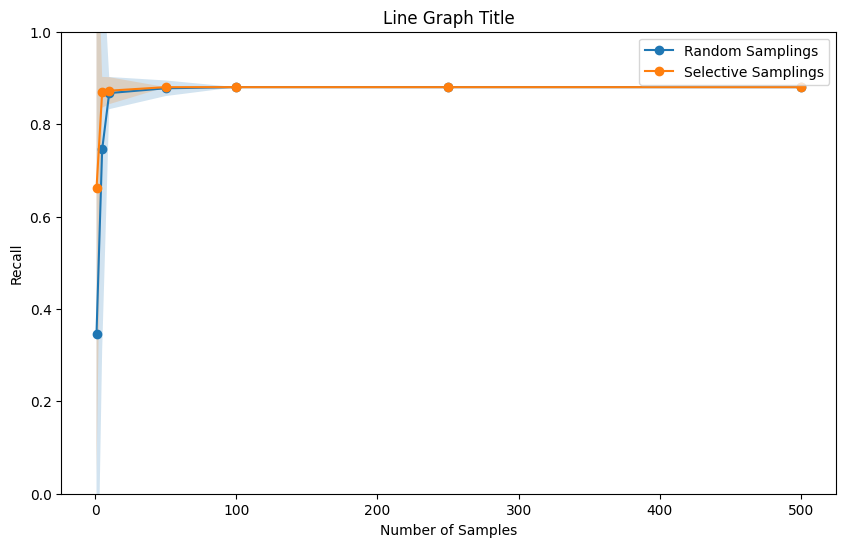

In [53]:
import matplotlib.pylab as plt

lists = sorted(recall_random_samplings.items()) # sorted by key, return a list of tuples
lists1 = sorted(recall_selective_samplings.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
x1, y1 = zip(*lists1)

# y_mean = [y[i].mean() for i in range (len(y))]
y_mean = np.vstack(y).mean(axis=1)
y_std = np.vstack(y).std(axis=1)

y1_mean = np.vstack(y1).mean(axis=1)
y1_std = np.vstack(y1).std(axis=1)

y_lower = y_mean - (y_std * 1.96)
y_upper = y_mean + (y_std * 1.96)

y1_lower = y1_mean - (y1_std * 1.96)
y1_upper = y1_mean + (y1_std * 1.96)

print ("x:", x)
print ("y:", y)

print ("y_mean:", y_mean)
print ("y_std:", y_std)


print ("y1:", y1)
print ("y1_mean:", y1_mean)
print ("y1_std:", y1_std)

plt.figure(figsize=(10, 6))

plt.plot(x, y_mean, marker='o', label="Random Samplings")
plt.fill_between(x, y_lower, y_upper, alpha=0.2)
plt.plot(x1, y1_mean, marker='o', label="Selective Samplings")
plt.fill_between(x1, y1_lower, y1_upper, alpha=0.2)
plt.xlabel("Number of Samples")
plt.ylabel("Recall")
plt.title("Line Graph Title")
plt.legend()
        
plt.gca().set_ylim([0, 1.0])
plt.show()